## Strategy Idea 3 : "Immediate price drift"

__Section 0: Setup__ Importing packages/reading in data etc.

__Section 1 : Idea__ 

- __1.1__ Strategy idea

- __1.2__ Origin of idea. Context/Reasoning for strategy to work e.g. use in financial markets?

__Section 2 : Exploration__

- __2.1__ Exploratory Data Analysis. e.g plots of price/volumes that could show strategy working, how much potential.

- __2.2__ Define some 'strategy metrics'. Metrics that can can you use to gauge if this strategy will work i.e no.price points above a certain threshold that is profitable. Metrics could show how often there is an opportunity to make a trade and how much 'value' is in an opportunity e.g. how much is there a price swing?

__Section 3 : Practical requirements__

- __3.1__ Identify if this edge is ‘realisable’? What methods will you apply to extract this value? e.g. applying a hedge function


- __3.2__ Is it possible to quantify the potential profit from the strategy? Consideration : How long will it take to obtain this? How 'risky' is it? e.g. if something did go wrong, how much do we lose? 

- __3.3__ Strategy limitations. The factors that could prevent strategy working e.g. practical considerations e.g. reacting quick enough to market updates, volume behind a price, size of bankroll needed


__Section 4: Potential limitations__

- __4.1__ What is our 'competition' - if not quantifiable, do we suspect people are doing the same thing? 

- __4.2__ So what's our edge? Identify ways of finding this edge in future? e.g what features are there? Are they predictive? Is there a certain 'market/runner' profile?

__Section 5 : Strategy testing__

- __5.1__ Testing strategy on previous data. 

- __5.2__ State any assumptions made by testing.

- __5.3__ Model refinements. How could strategy be optimised? Careful : is this backfitting/overfitting - what measures taken to negate this e.g. bootstrapping?

- __5.4__ Assessing strategy. P/L on data sample? ROI? variance in results? longest losing run?



### Section 0 : Setup

In [28]:
# importing packages
from pathlib import Path, PurePath 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import utils

In [29]:
# reading in data
project_dir = Path.cwd().parents[2]
data_dir = project_dir / 'data' / 'processed' / 'api' / 'advanced' / 'adv_data.csv'
df = pd.read_csv(data_dir, index_col = 0)
print(df.shape)

(13073, 307)


In [30]:
# defining variables
back_prices = [col for col in df.columns if 'BP' in col]
back_sizes = [col for col in df.columns if 'BS' in col]
lay_prices = [col for col in df.columns if 'LP' in col]
lay_sizes = [col for col in df.columns if 'LS' in col]

runner_info = ['SelectionId', 'MarketId', 'Venue', 'Distance', 'RaceType', 'BSP', 'NoRunners']

In [31]:
def payout(bp, bs, lp, ls, c):
    if ls == '?':
        ls = lay_hedge_stake(bp, bs, lp, c)
    elif bs == '?':
        bs = bet_hedge_stake(lp, ls, bp, c)
    loss_side = - bs + ls * (1 - c) 
    win_side = (bp - 1) * bs * (1 - c) - (lp - 1) * ls
    return win_side 

def lay_hedge_stake(bp, bs, lp, c):
    return round((((bp - 1) * bs * (1 - c)) + bs) / (lp - c), 2)

def bet_hedge_stake(lp, ls, bp, c):
    return ls * (lp - c) / (bp * (1 - c) + c)

In [32]:
def plot_df():
    plot_df = df[df['BSP'].notna()].sample(1).copy() # 60 NA BSP's

    bp_df = plot_df[['SelectionId'] + back_prices].copy()
    bp_df.columns = bp_df.columns.str.replace("[BP:T]", "")
    bp_df.columns = bp_df.columns.str.replace("[+]", "")
    bp_df = pd.melt(bp_df, id_vars = ['SelectionId'])
    bp_df['variable'] = bp_df['variable'].astype(int)

    lp_df = plot_df[['SelectionId'] + lay_prices].copy()
    lp_df.columns = lp_df.columns.str.replace("[LP:T]", "")
    lp_df.columns = lp_df.columns.str.replace("[+]", "")
    lp_df = pd.melt(lp_df, id_vars = ['SelectionId'])
    lp_df['variable'] = lp_df['variable'].astype(int)

    bsp_df = plot_df[['BSP']].copy()
    
    prof_lp_df_gt0 = lp_df.copy()
    prof_lp_df_gt0['profit'] = prof_lp_df_gt0['value'].apply(lambda x: payout(bsp_df['BSP'].item(), 10, x, '?', 0))  #btl
    prof_lp_df_gt0 = prof_lp_df_gt0.loc[prof_lp_df_gt0['variable'] > 0].copy()
    
    prof_bp_df_lt0 = bp_df.copy()
    prof_bp_df_lt0['profit'] = prof_bp_df_lt0['value'].apply(lambda x: payout(x, 10, bsp_df['BSP'].item(), '?', 0)) #btl
    prof_bp_df_lt0 = prof_bp_df_lt0.loc[prof_bp_df_lt0['variable'] < 0].copy()
    
    prof_bp_df_gt0 = bp_df.copy()
    prof_bp_df_gt0['profit'] = prof_bp_df_gt0['value'].apply(lambda x: payout(x, '?', bsp_df['BSP'].item(), 10, 0))  #ltb    
    prof_bp_df_gt0 = prof_bp_df_gt0.loc[prof_bp_df_gt0['variable'] > 0].copy()
    
    prof_lp_df_lt0 = lp_df.copy()
    prof_lp_df_lt0['profit'] = prof_lp_df_lt0['value'].apply(lambda x: payout(bsp_df['BSP'].item(), '?', x, 10, 0))   #ltb
    prof_lp_df_lt0 = prof_lp_df_lt0.loc[prof_lp_df_lt0['variable'] < 0].copy()
    
    return bp_df, lp_df, bsp_df, prof_bp_df_gt0, prof_lp_df_gt0, prof_bp_df_lt0 , prof_lp_df_lt0

### Section 1 : Idea

__1.1 Idea__

Hedge bets can be started at any given pre-race price and **always** closed out at BSP, or opened at BSP and closed out inplay with some degree of probability of a non-matched bet. The following graphs show when there were profitable hedge opportunities with these methods.

__1.2  Reasoning__

This is purely technical analysis, but if there are any tendencies that repeat more than 50% of the time which can be exploited, or if there are optimal times to start the hedge, this is useful information.

### Section 2 : Exploration

__2.1__ Plots

__Plot of Back/Lay Price and SP with profit graphs from all four hedge types__

Taking a random runner from the sample and plotting their Back and Lay price over time. 

Note : every time you run the cell a different runner will be chosen to plot - spam CTRL + ENTER

(array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]),
 <a list of 9 Text yticklabel objects>)

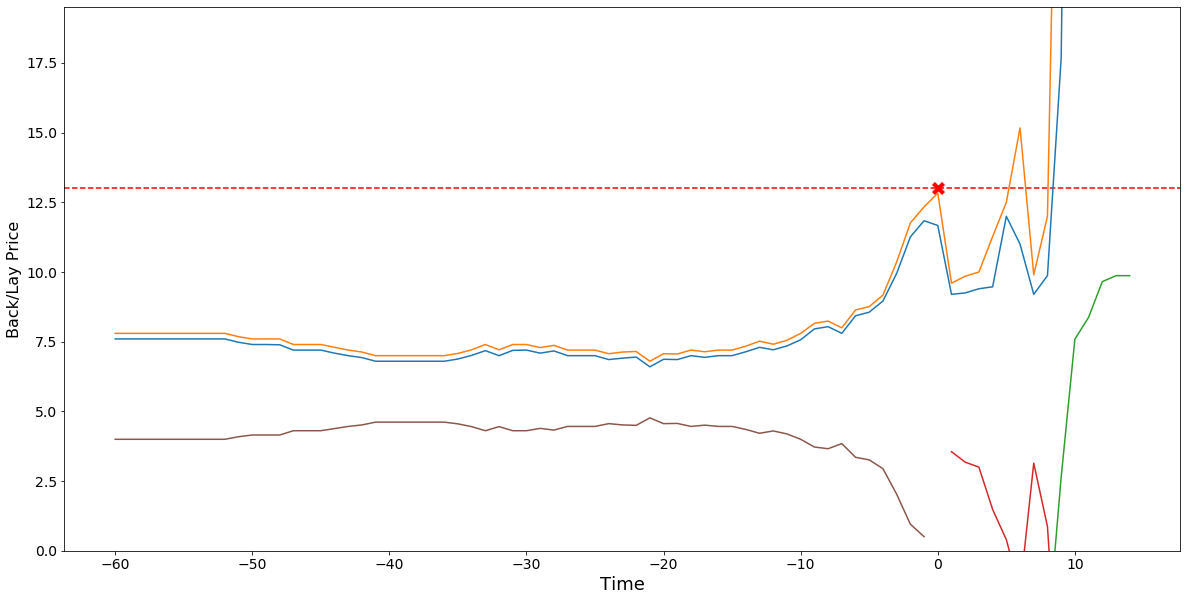

In [46]:
bp_df, lp_df, bsp_df, prof_bp_df_gt0, prof_lp_df_gt0, prof_bp_df_lt0, prof_lp_df_lt0 = plot_df()

# set plotting parameters
plt.figure(figsize=(20,10))
plt.ylim(0, bsp_df['BSP'].item() * 1.5) # limit y axis

# plotting
sns.scatterplot(0, y = bsp_df['BSP'], marker = 'X', s=200, color = 'r')
plt.axhline(y=bsp_df['BSP'].item(), color='r', linestyle='--')

sns.lineplot(x = 'variable', y = 'value', data = bp_df, ci = None)

sns.lineplot(x = 'variable', y = 'value', data = lp_df, ci = None)

sns.lineplot(x = 'variable', y = 'profit', data = prof_bp_df_gt0, ci = None)

sns.lineplot(x = 'variable', y = 'profit', data = prof_lp_df_gt0, ci = None)

sns.lineplot(x = 'variable', y = 'profit', data = prof_bp_df_lt0, ci = None)

sns.lineplot(x = 'variable', y = 'profit', data = prof_lp_df_lt0, ci = None)


# plot formatting
plt.xlabel('Time', fontsize=18)
plt.ylabel('Back/Lay Price', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

When the purple, brown, green or red lines are present, there were profitable hedge opportunities closing out at SP for when the first bet was made before t=0 or closing out at the prevailing price when the first bet was made at SP.